### CSCI E-82  Homework 5 on CNNs

### Due by 11/13/18 at 11:59pm EST to the Canvas dropbox

## This is an individual homework so there should be no collaboration for this homework.


### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.


This is a busy time of year with homework and an exam coming up.  We are looking for a successful working result that builds upon the section code and enables you to gain some proficiency with this important and growing field of deep learning. 

Depending on your computer, some of the runs may still take a few minutes per epoch.  As a result, Problem 4 may take the better part of a day to run, so plan accordingly.  

## Your Name: 

## SHARJIL KHAN

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD


from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

Using TensorFlow backend.


Tensorflow is installed and is version:  1.11.0
Keras is installed and is version:  2.1.6-tf
[[22. 28.]
 [49. 64.]]


In [2]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [30]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

In [3]:

print(sys.version)


print(device_lib.list_local_devices())



3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6930927388773376543
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8496168656199406774
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [5]:
#TensorBoard --logdir tf_summary --port 8080

## Dataset

WikiArt is an amazing resource containing centuries of artwork.  Since such datasets are wonderful for deep learning, Kaggle has hosted a challenge to characterize the 'fingerprints' of various artists.  The Kaggle dataset contains metadata and also a set of images that have been resized so that the shorter dimension is 256 pixels.  To make this homework reasonably fast even for those without GPUs, we have further reduced the images to 64 x 64.  CNNs and neural networks in general prefer to have consistent sizes.  To achieve this, we cut the center 256 pixels from the longer dimension and then shrunk the images by a factor of 4. This isn't a perfect solution since it did cut off a few heads as you will see.

The selected images are for portraits and landscapes.  No, we're not talking about the orientation but rather the content of the images. Thanks to help from Rashmi and Dave, we have a small enough data set that should give reasonable results in a timely manner even on just a CPU.

The data were originally divided into a training and a test set.  We have further divided the training set into a train and validation set.  In this homework you will be using the training set and validation set to train and assess your deep learning models.  At the final step, you will see how well your final training worked on the test set.  In each of these directories, there is a truth.txt file that has the image name and whether it is a portrait or landscape scene.

## Problem 1 (5 points)

Read in and display the first 5 portraits and the first 5 landscapes.  Note, if you are using the OpenCV tools, then the color may be distorted.  The cvtColor() method using cv2.COLOR_BGR2RGB may be useful.  However, it is likely easier to use the generator and plot_strip example from section.

In [6]:
def organize_folders (base_dir):
    truth_file = os.path.join(base_dir,'truth.txt')
    portrait_dir = os.path.join(base_dir, 'portrait')
    landscape_dir = os.path.join(base_dir, 'landscape')

    # CREATE THE TWO FOLDERS IF THEY DONT EXIST ALREADY
    if not os.path.exists(portrait_dir):
             os.makedirs(portrait_dir)
    if not os.path.exists(landscape_dir):
             os.makedirs(landscape_dir)

    with open(truth_file) as f:
        for line in f:
            data = line.split()
            image_file = os.path.join(base_dir, data[0])
            image_type = data[1]
            if os.path.exists(image_file):
                if os.path.getsize(image_file) > 0:
                        if image_type == 'portrait':
                              shutil.move(image_file, portrait_dir)
                        if image_type == 'landscape':
                              shutil.move(image_file, landscape_dir)    
                print ("Moving:%s to %s"%(image_file,image_type))
            

In [7]:
# All images will be rescaled by 1./255
train_dir = './images64/train'
validation_dir = './images64/validation'
test_dir = './images64/test'

organize_folders(train_dir)
organize_folders(validation_dir)
organize_folders(test_dir)

datagen = ImageDataGenerator(rescale=1./255)

# generator for the training data
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# generator for the validation data
validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

# generator for the test data
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=40,  # this just makes sure it gets through memory
        class_mode='binary')



Found 16315 images belonging to 2 classes.
Found 8158 images belonging to 2 classes.
Found 7379 images belonging to 2 classes.


In [8]:
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
print(labels_batch)

data batch shape: (40, 64, 64, 3)
labels batch shape: (40,)
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.]


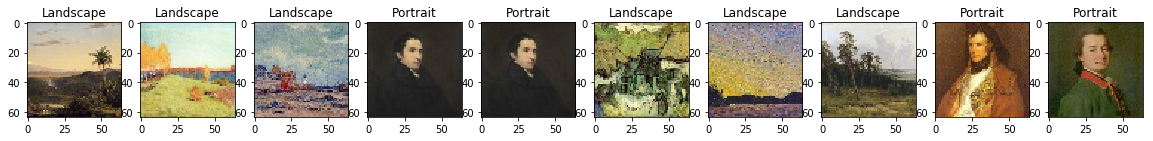

In [9]:
def plot_strip(data, labels):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    f, ax = plt.subplots(nrows=1, ncols=10)

    for i, j in enumerate(np.random.randint(0,labels.shape[0], size=10)):
        #ax[i].axis('off')
        ax[i].set_title(['Landscape', 'Portrait'][int(labels[j])], loc='center')
        ax[i].imshow(data[j,:,:], cmap='gray')
       
plot_strip(data_batch, labels_batch)

test = image.load_img('images64/train/landscape/1000.jpg')


## Problem 2 (25 points)

Construct a baseline CNN classifier using Keras for the training set and assess the validation set performance at each epoch. The goal is to correctly classify portraits from landscapes. Plot the resulting performance on the training and validation set as a function of epoch using the criteria over which you are optimizing.  You should run at least 20 epochs for this problem.

In [10]:
K.clear_session()

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

def simple_model():

    model = Sequential(name='SimpleModel')
    model.add(Conv2D(32, (4, 4), strides = (1, 1), padding='same',activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool1'))
    model.add(Conv2D(64, (4, 4), strides = (1, 1), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), strides=2, padding='valid', name='max_pool2'))
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))
    
    sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

cnn1 = simple_model()
cnn1.summary()

# Fit model
history = cnn1.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[tensorboard])

#val_loss, val_acc = cnn1.evaluate_generator(validation_generator, steps=100)
test_loss, test_acc = cnn1.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        1568      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        32832     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              16778240  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 1025      
Total para

## Problem 3 (5 points)

From the pattern of training and validation curves, describe what is good/bad and what you plan to do next to improve the result.

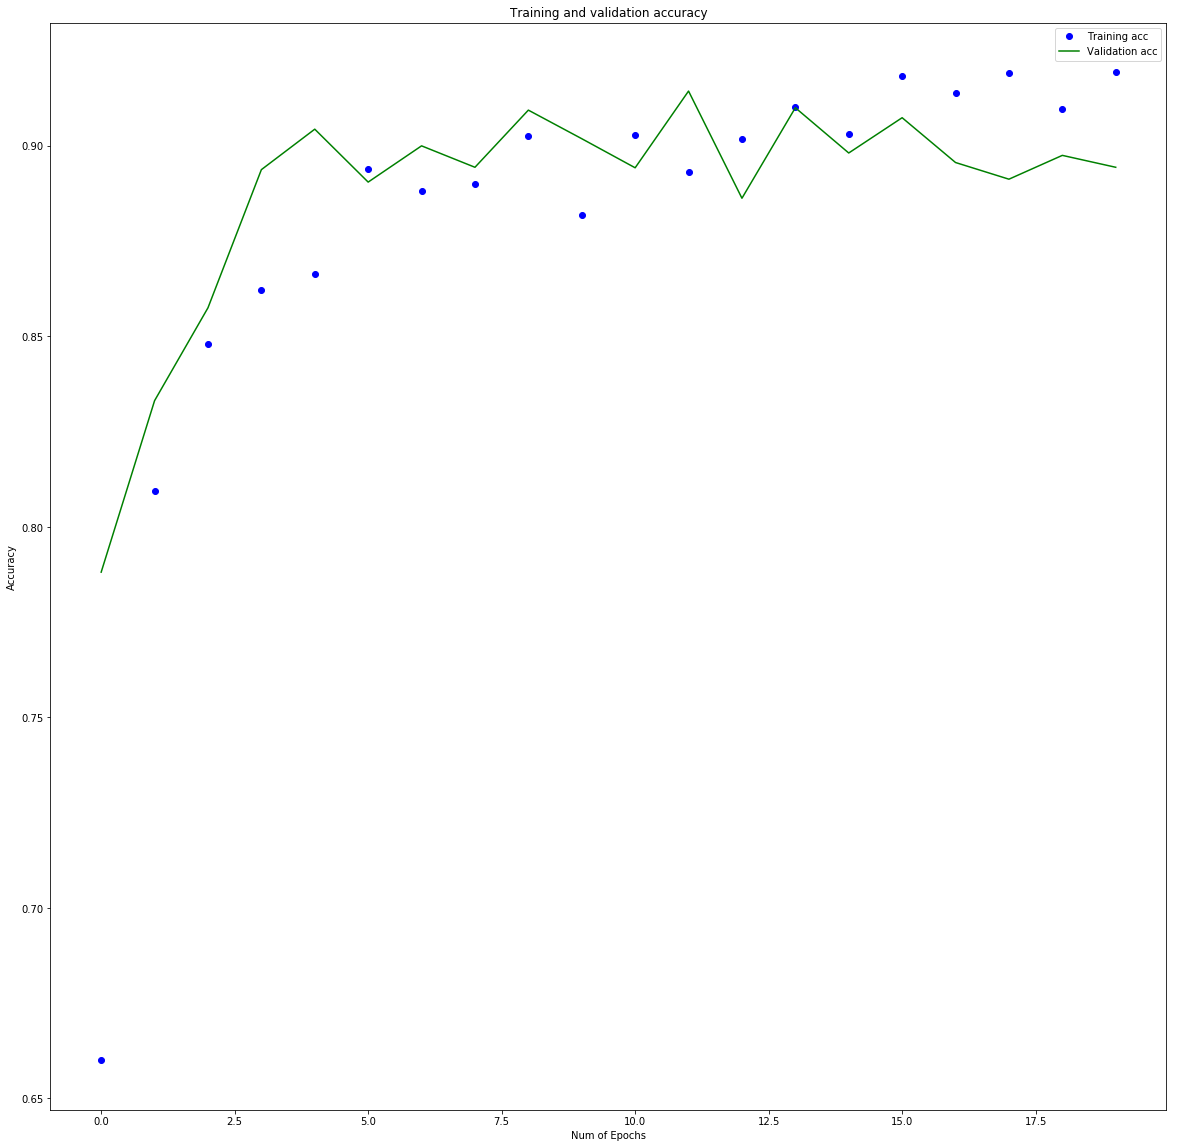

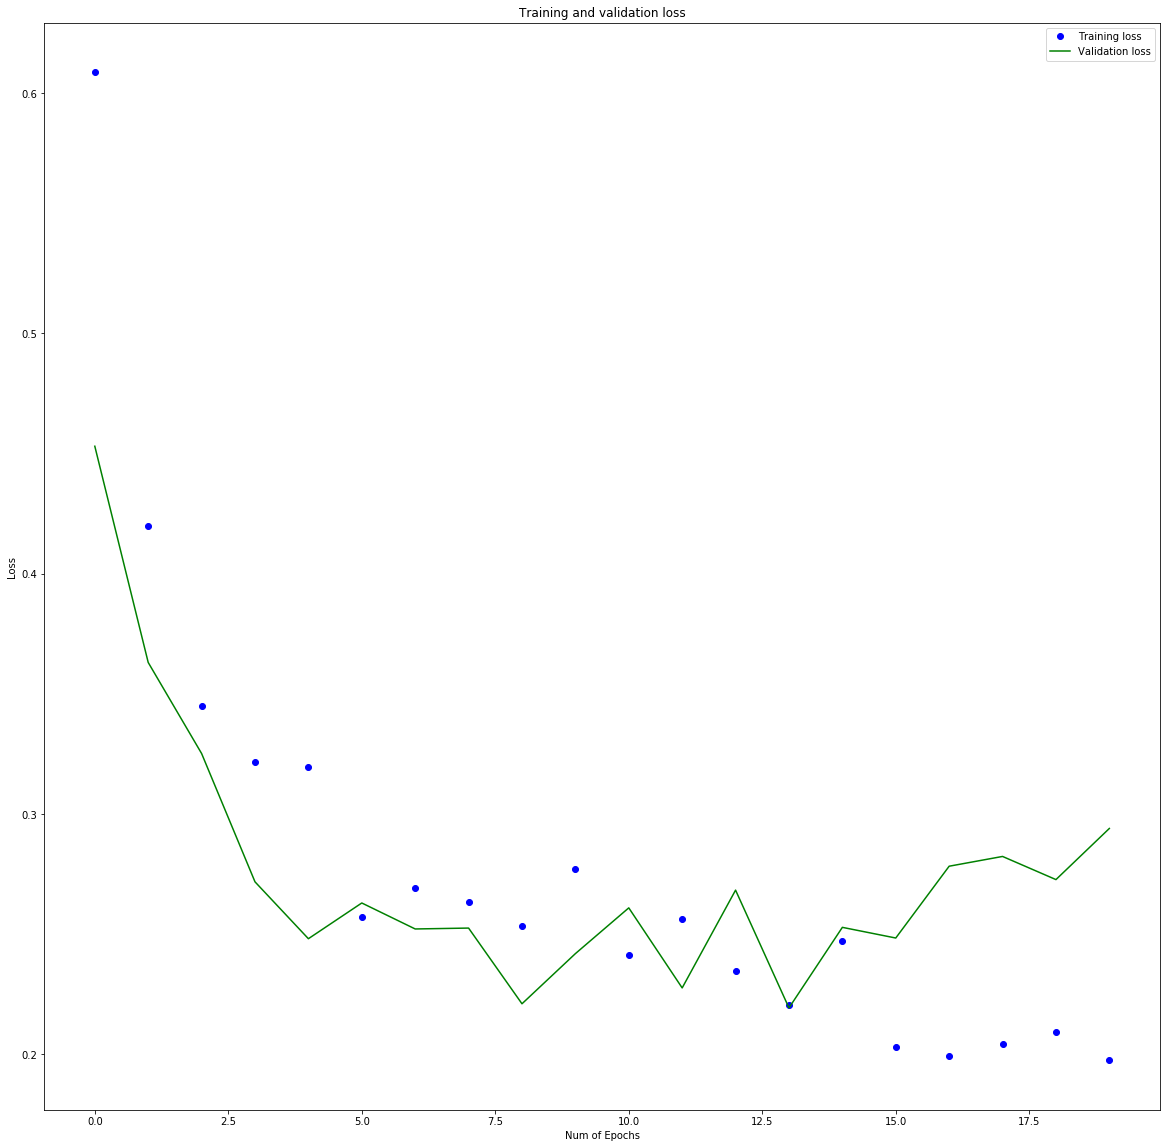

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g-', label='Validation loss')
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Problem 4 (45 points)

This step is where we want you to do most of your personal learning.  Your goal is to improve the network using a combination of architecture choices, parameter tuning, and experimenting with different optimizers/dropout/regularization/etc. Treat each of these as separate optimization/exploration steps for now.  We would like to see 3 separate steps that cover different areas.  The format of the 3 steps should be as follows:
  * State the hypothesis/strategy for how you will improve/explore a particular aspect.
  * Describe what types of tests you are running and why (i.e. what range of parameters are you choosing and why)
  * Include the code and results
  * State your interpretation of the results
 
We're not looking for research in deep learning, but we want you to gain some hands-on experience working with Keras and figuring out what works. A good example may be comparing strategies to overcome overfitting, or comparing a few different CNN architectures in terms of performance and speed, or comparing data augmentation types and results.  
 


## Problem 5 (10 points)

Assess your best model on the test data.  Plot the corresponding ROC curve from the results (since we've provided the truth).  This was not directly covered in section, but will require a prediction using images in the same format as the training.  We suggest referring to the Keras API else use a Google to search to find how to make predictions.

## Problem 6 (5 points)

Display the 5 images [worst] misclassified images for each class.  Worst is in brackets since certain architectures may only make a binary decision rather than a score.  In that case, plot 5 of each.

## Problem 7 (2 points)
How many hours did this homework take you? The answer to this question will not affect your grade.

## Last step (3 points)
Save this notebook as LastnameFirstnameHW5.ipynb such as PriceDavid.ipynb. Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.